In [89]:
import pandas as pd

building_metadata = pd.read_csv('data/building_metadata.csv', dtype={'building_id': 'int16'})
building_meter_readings = pd.read_csv('data/building_meter_readings.csv', parse_dates=['timestamp'], dtype={'meter': 'int16', 'meter_reading': 'float64', 'building_id': 'int16'})
weather_data = pd.read_csv('data/weather_data.csv', parse_dates=['timestamp'])

# Join all data
data = pd.merge(building_meter_readings, building_metadata, on='building_id')
data = pd.merge(data, weather_data, on=['site_id', 'timestamp'])

print(len(data))
# remove meter_reading 0 values
data = data[data['meter_reading'] > 0]
print(len(data))


20125605
18257718


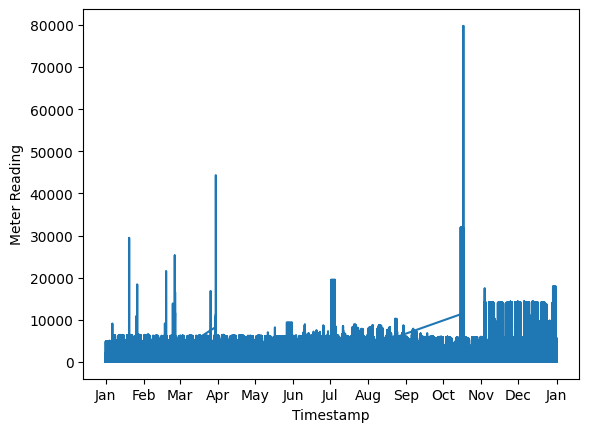

In [90]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

# plot meter readings for building 0
building_0 = data[data['building_id'] == 0]
# plot only meter 0
building_0 = data[data['meter'] == 0]

xpoints = building_0['timestamp']
ypoints = building_0['meter_reading']

plt.plot(xpoints, ypoints)
plt.xlabel("Timestamp")
plt.ylabel("Meter Reading")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.show()

# Select features


In [92]:
import numpy as np
import gc
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold

SEED =42

target = data['meter_reading']
data.drop(columns=['meter_reading'], inplace=True)
df_train = data

lgb_param = {
    'num_leaves': 2**9,
    'learning_rate': 0.05,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'feature_fraction': 0.8,
    'feature_fraction_bynode': 0.7,
    'min_data_in_leaf': 1000,
    'max_depth': -1,
    'objective': 'regression',
    'seed': SEED,
    'feature_fraction_seed': SEED,
    'bagging_seed': SEED,
    'drop_seed': SEED,
    'data_random_seed': SEED,
    'boosting_type': 'gbdt',
    'verbose': 1,
    'metric': 'rmse',
}

CATEGORICALS = ['building_id', 'meter', 'primary_use', 'HourOfDay', 'DayOfWeek', 'site_id']
N = 5
kf = KFold(n_splits=N)

importance = pd.DataFrame(np.zeros((df_train.shape[1] - 1, N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=df_train.drop(columns=['timestamp']).columns)
scores = []
oof = np.zeros(df_train.shape[0])
models = []

for fold, (trn_idx, val_idx) in enumerate(kf.split(df_train), 1):
    print('Fold {}'.format(fold))

    trn_data = lgb.Dataset(df_train.iloc[trn_idx, :].drop(columns=['timestamp']), label=target.iloc[trn_idx], categorical_feature=CATEGORICALS)
    val_data = lgb.Dataset(df_train.iloc[val_idx, :].drop(columns=['timestamp']), label=target.iloc[val_idx], categorical_feature=CATEGORICALS)

    model = lgb.train(lgb_param, trn_data, 200, valid_sets=[trn_data, val_data], verbose_eval=50)
    models.append(model)

    predictions = model.predict(df_train.iloc[val_idx, :].drop(columns=['timestamp']), num_iteration=model.best_iteration)
    importance.iloc[:, fold - 1] = model.feature_importance()
    oof[val_idx] = predictions

    score = np.sqrt(mean_squared_error(target.iloc[val_idx].values, predictions))
    scores.append(score)
    print('Fold {} RMSLE {}\n'.format(fold, score))

    del trn_data, val_data, predictions
    gc.collect()

print('Mean RMSLE {} [STD:{}]'.format(np.mean(scores), np.std(scores)))
print('OOF RMSLE {}'.format(np.sqrt(mean_squared_error(target, oof))))


KeyError: 'meter_reading'